# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 21.09.2020

Мягкий дедлайн: 02:59MSK 05.10.2020

Жесткий дедлайн: 23:59MSK 08.10.2020

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 10.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1352]:
!pip install folium

In [1353]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [1354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [1355]:
data = pd.read_csv(r'train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [1356]:
data.drop('dropoff_datetime', axis='columns', inplace=True)
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Разбейте выборку на обучающую и тестовую в отношении 7:3.

In [1357]:
from sklearn.model_selection import train_test_split

y = data["trip_duration"]
X = data.drop(columns=["trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

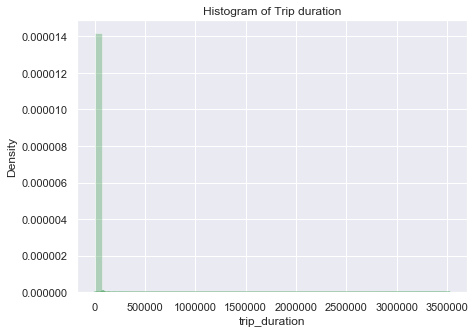

In [1358]:
plt.figure(figsize=(7,5))
sns_plot = sns.distplot(y_train, color = 'g')
plt.title("Histogram of Trip duration")
plt.ylabel("Density")
fig = sns_plot.get_figure()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: Можно сказать, что бОльшая часть значений лежит в диапазоне до 500000 (даже меньше), однако есть значения гораздо больше, что может помешать при чувствительности функции потерь к выбросам.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: На примерах можно заметить, что RMSLE гораздо лучше работает с выбросами, а так как в нашей выборке их много, нам выгоднее работать с такой метрикой качества.
$$\text{Пример: } a(x) = 677891; y = 608090 \Rightarrow \text{RMSE} = 4.242, \text{RMSLE} = 0.6466$$
$$\text{При выбросах: } a(x) = 677891102; y = 608090750 \Rightarrow \text{RMSE} = 374.724, \text{RMSLE} = 1.160$$
Более подробное объяснение можно найти здесь: https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: 
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(\exp(\hat{y_i}) - 1 + 1)} - \log{(\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(\exp(\hat{y_i}))} - \log{(\exp(\hat{a}(x_i)))}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \hat{a}(x_i)\big)^2} = \text{RMSE}(X, \hat{y}, \hat{a})$$
А на семинаре говорилось о том, что оптмизация RMSE эквивалентна оптимизации MSE, так как корень это монотонное
преобразование, и оно не меняет минимум функции.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашим выборкам колонки `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке:

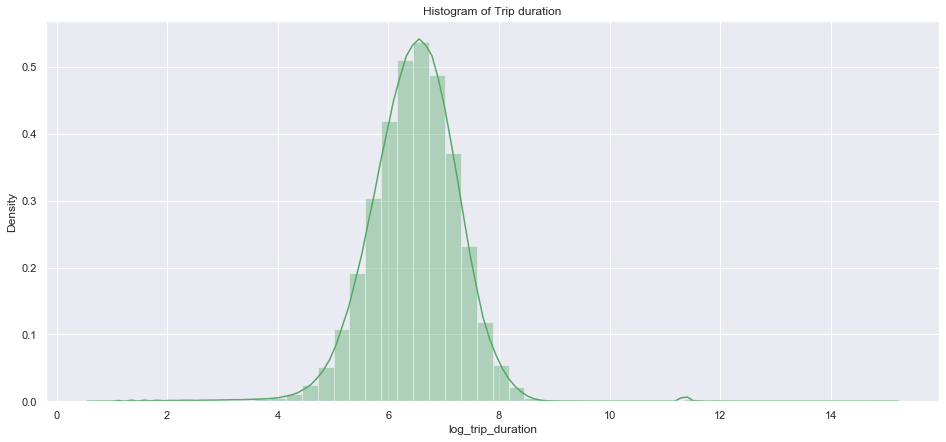

In [1359]:
X_train['log_trip_duration'] = np.log1p(y_train)
X_test['log_trip_duration'] = np.log1p(y_test)
y_log_train = X_train['log_trip_duration']
y_log_test = X_test['log_trip_duration']
plt.figure(figsize=(16,7))
sns_plot = sns.distplot(y_log_train , color = 'g')
plt.title("Histogram of Trip duration")
plt.ylabel("Density")
fig = sns_plot.get_figure()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [1360]:
from sklearn.metrics import mean_squared_error

y_log_pred_train = np.full(len(y_log_train), y_log_train.mean())
print("Train MSE = %.4f" % mean_squared_error(y_log_train, y_log_pred_train, squared=True))
y_log_pred_test = np.full(len(y_log_test), y_log_train.mean())
print("Test MSE = %.4f" % mean_squared_error(y_log_test, y_log_pred_test, squared=True))

Train MSE = 0.6333
Test MSE = 0.6331


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

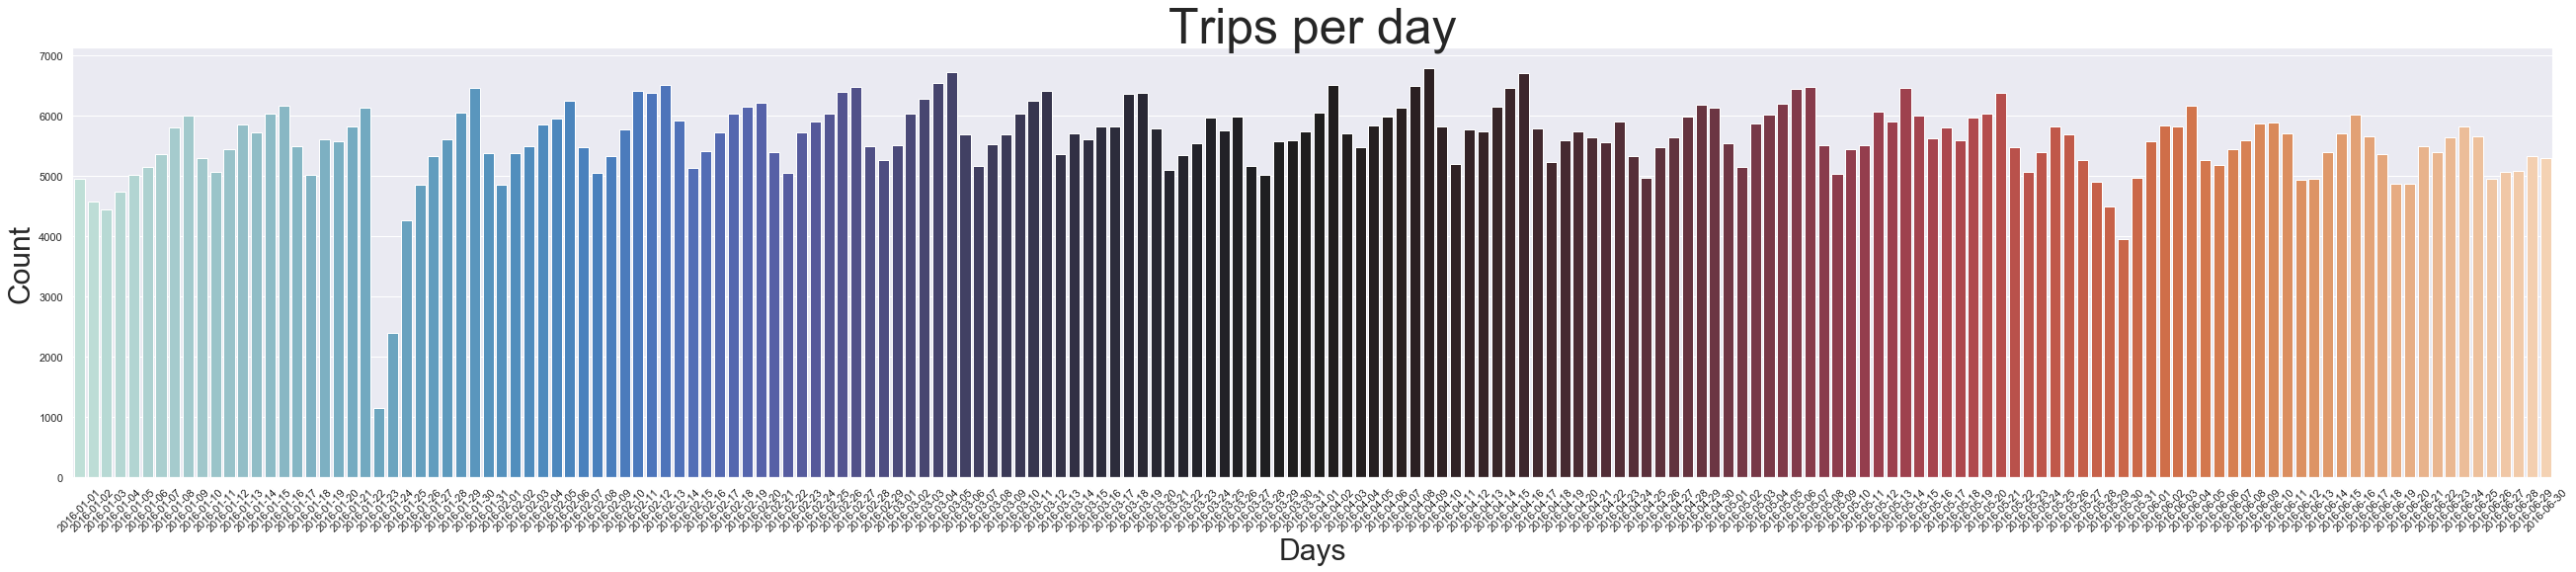

In [1361]:
pickup_date = X_train['pickup_datetime'].dt.date.sort_values()
plt.figure(figsize=(45,8))
plt.xticks(rotation=45)
sns_plot = sns.countplot(x=pickup_date, data=X_train, palette="icefire")
plt.title("Trips per day", fontsize = 50)
plt.xlabel('Days',fontsize = 30)
plt.ylabel('Сount', fontsize = 30)
fig = sns_plot.get_figure()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ:** Судя по гистограмме даты: 23 января - 24 января -- *Власти запретили автомобильное движение в Нью-Йорке из-за снежной бури*, 30 мая -- *День Памяти (Memorial Day) в Нью-Йорке*.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

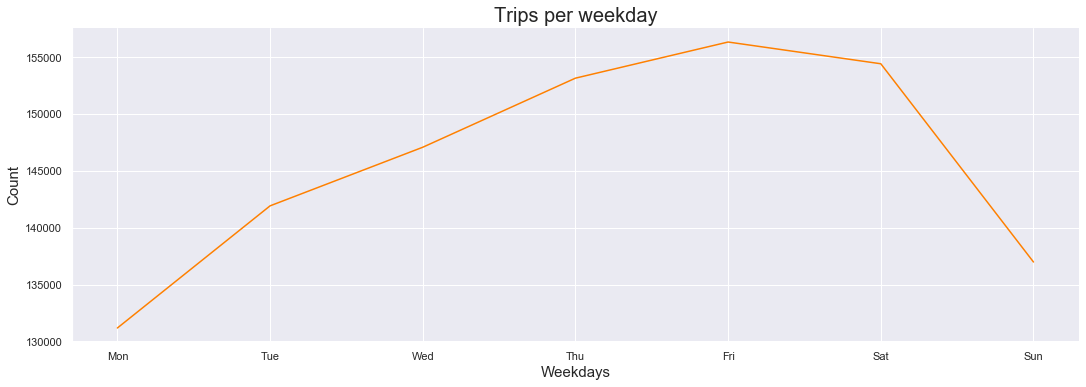

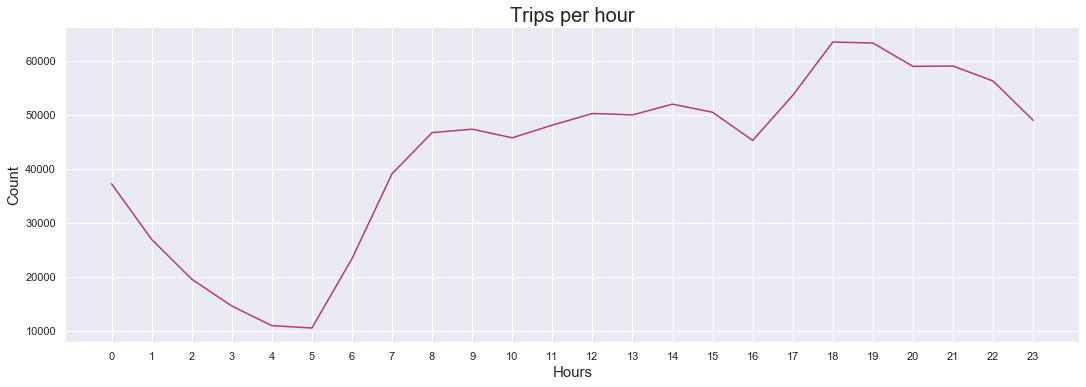

In [1362]:
pickup_weekday_cnt = data.groupby(X_train['pickup_datetime'].dt.weekday, as_index=True).count()['id']
weekday_cnt = pickup_weekday_cnt.to_frame()
sns.relplot(data=weekday_cnt, kind='line', palette='autumn', legend=False, aspect=3)
plt.title("Trips per weekday", fontsize = 20)
plt.xlabel('Weekdays',fontsize = 15)
plt.ylabel('Сount', fontsize = 15)
plt.xticks(np.arange(7), np.array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

pickup_hour_cnt = data.groupby(X_train['pickup_datetime'].dt.hour, as_index=True).count()['id']
hour_cnt = pickup_hour_cnt.to_frame()
sns.relplot(data=hour_cnt, kind='line', palette='magma', legend=False, aspect=3)
plt.title("Trips per hour", fontsize = 20)
plt.xlabel('Hours',fontsize = 15)
plt.ylabel('Сount', fontsize = 15)
plt.xticks(np.arange(24))
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

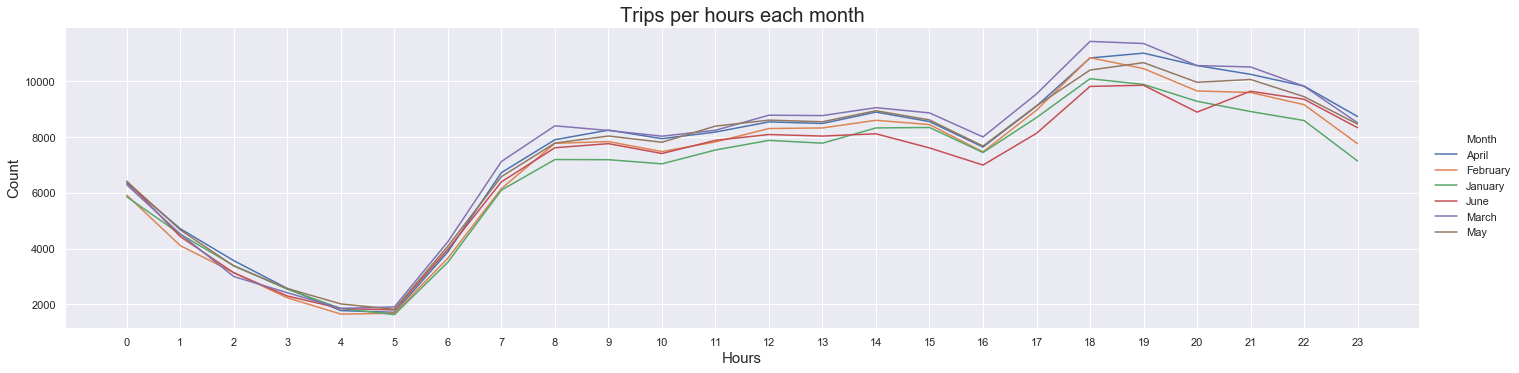

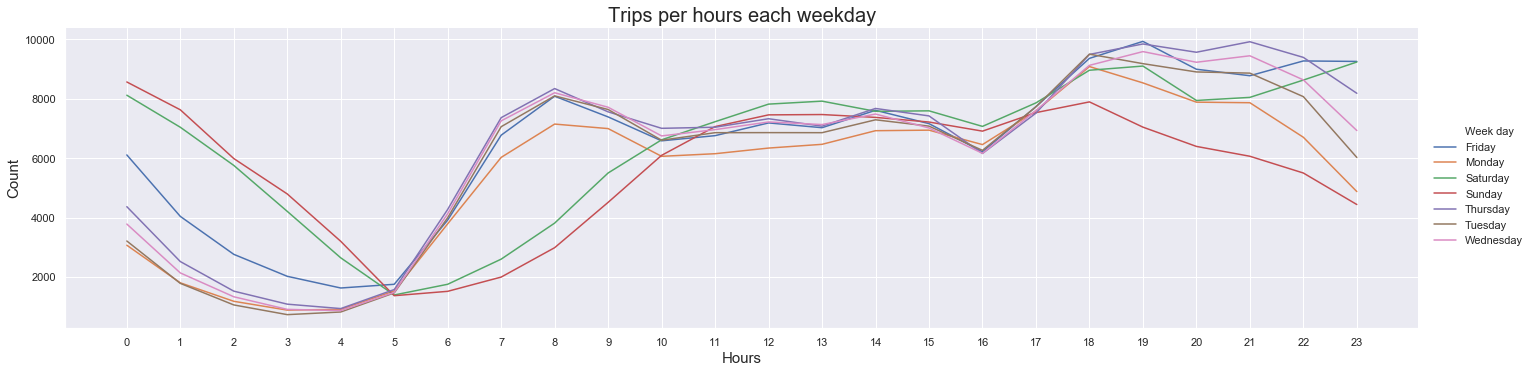

In [1363]:
X_train['Hour'] = X_train['pickup_datetime'].dt.hour
X_train['Month'] = X_train['pickup_datetime'].dt.strftime('%B')
datas = X_train.groupby(['Hour', 'Month'], as_index=False).count()
sns.relplot(data=datas, x='Hour', y='id', kind='line', hue='Month', legend='full', aspect=4)
plt.title("Trips per hours each month", fontsize = 20)
plt.xlabel('Hours',fontsize = 15)
plt.ylabel('Сount', fontsize = 15)
plt.xticks(np.arange(24))


X_train['Week day'] = X_train['pickup_datetime'].dt.strftime('%A')
datas = X_train.groupby(['Hour', 'Week day'], as_index=False).count()
sns.relplot(data=datas, x='Hour', y='id', kind='line', hue='Week day', legend='full', aspect=4)
plt.title("Trips per hours each weekday", fontsize = 20)
plt.xlabel('Hours',fontsize = 15)
plt.ylabel('Сount', fontsize = 15)
plt.xticks(np.arange(24))
plt.show()

X_train.drop(['Month'], axis='columns', inplace=True)
X_train.drop(['Week day'], axis='columns', inplace=True)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: На обоих графиках 5 часов утра -- самое редко время для поездок, а промежкток с 18 до 19 -- самое частое. По воскресеньям и субботам редко ездят по утрам, однако чаще остальных дней ездят в промежутке с 12 до 4 ночи. Скорее всего, это связано с временем поездок на работу. Самый частый месяц для поездок -- Март.

**Задание 4 (0.5 баллов)**. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

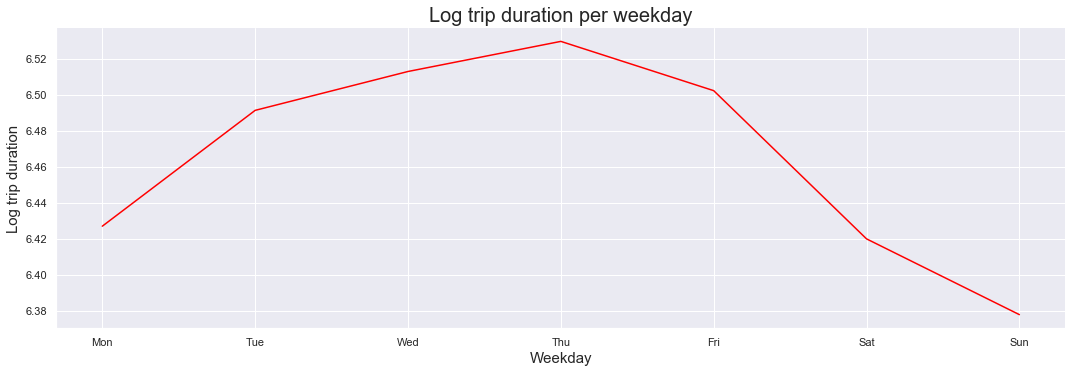

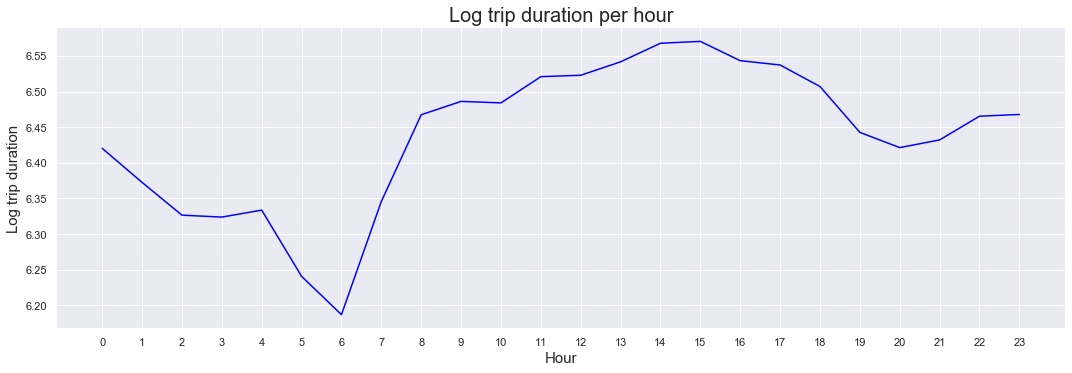

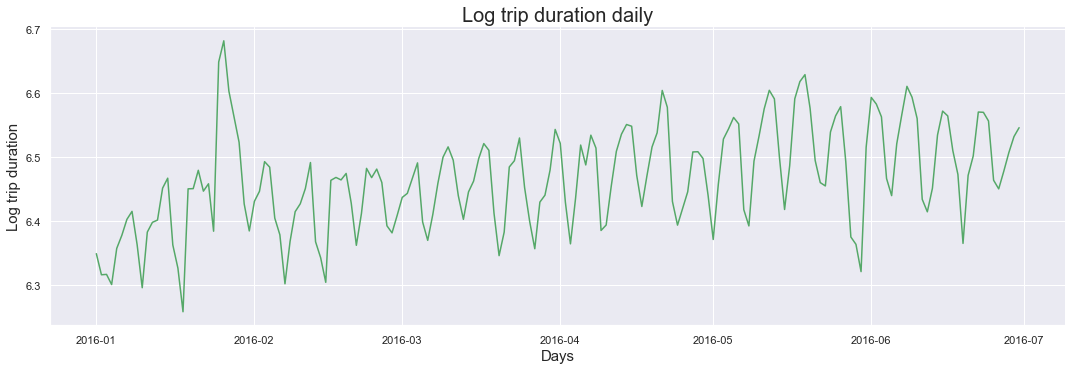

In [1364]:
X_train['Weekday'] = X_train['pickup_datetime'].dt.weekday
datas = X_train.groupby(['Weekday'], as_index=False)['log_trip_duration'].mean()
sns.relplot(data=datas, x='Weekday', y='log_trip_duration', kind='line', color='red', aspect=3)
plt.title("Log trip duration per weekday", fontsize = 20)
plt.xlabel('Weekday',fontsize = 15)
plt.ylabel('Log trip duration', fontsize = 15)
plt.xticks(np.arange(7), np.array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

datas = X_train.groupby(['Hour'], as_index=False)['log_trip_duration'].mean()
sns.relplot(data=datas, x='Hour', y='log_trip_duration', kind='line', color='blue', aspect=3)
plt.title("Log trip duration per hour", fontsize = 20)
plt.xlabel('Hour',fontsize = 15)
plt.ylabel('Log trip duration', fontsize = 15)
plt.xticks(np.arange(24))

X_train['date'] = X_train['pickup_datetime'].dt.date
datas = X_train.groupby(['date'], as_index=False)['log_trip_duration'].mean()
sns.relplot(data=datas, x='date', y='log_trip_duration', kind='line', color='g', aspect=3)
plt.title("Log trip duration daily", fontsize = 20)
plt.xlabel('Days',fontsize = 15)
plt.ylabel('Log trip duration', fontsize = 15)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: Графики очень похожи, так как от числа поездок зависит и длительность, а значит и логарифм длительности.На графике зависимости среднего логарифма от дня в даты аномальных периодов продолжительность поездок так же очень низкая, так как тогда было маленькое число поездок. В качестве тренда можно выделить скачкообразную структуру графика.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [1365]:
X_train['Month'] = X_train['pickup_datetime'].dt.month
X_train['Day'] = X_train['pickup_datetime'].dt.dayofyear
X_train['1st_anomal'] = 0
X_train['2nd_anomal'] = 0
X_train.loc[(X_train['pickup_datetime'].dt.date == pd.Timestamp('2016-01-23')) |\
            (X_train['pickup_datetime'].dt.date == pd.Timestamp('2016-01-24')), '1st_anomal'] = 1
X_train.loc[X_train['pickup_datetime'].dt.date == pd.Timestamp('2016-05-30'), '2nd_anomal'] = 1
X_train.drop('date', axis='columns', inplace=True)

X_test['Hour'] = X_test['pickup_datetime'].dt.hour
X_test['Weekday'] = X_test['pickup_datetime'].dt.weekday
X_test['Month'] = X_test['pickup_datetime'].dt.month
X_test['Day'] = X_test['pickup_datetime'].dt.dayofyear
X_test['1st_anomal'] = 0
X_test['2nd_anomal'] = 0
X_test.loc[(X_test['pickup_datetime'].dt.date == pd.Timestamp('2016-01-23')) |\
            (X_test['pickup_datetime'].dt.date == pd.Timestamp('2016-01-24')), '1st_anomal'] = 1
X_test.loc[X_test['pickup_datetime'].dt.date == pd.Timestamp('2016-05-30'), '2nd_anomal'] = 1
X_train = X_train.drop(columns=["pickup_datetime"])
X_test = X_test.drop(columns=["pickup_datetime"])

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ**: Из представленных признаков категориальными можно сделать день недели, месяц и аномальность, так как их некорректно сравнивать, что больше, то есть не можем задать порядок; а числовые -- час и номер дня в году.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [1366]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical = ['Month', 'Weekday', '1st_anomal', '2nd_anomal']
numeric_features = ['Day', 'Hour']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[[*categorical, *numeric_features]], y_log_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("Test MSE = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

Test MSE = 0.6280


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [1367]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [1368]:
df = data

In [1369]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [1370]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ**: Два аэропорта: John F. Kennedy и LaGuardia.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [1371]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


X_train.loc[:, 'haversine'] = haversine_array(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values,\
                                                     X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_test.loc[:, 'haversine'] = haversine_array(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values,\
                                                     X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [1372]:
X_train.loc[:, 'log_haversine'] = np.log1p(X_train.loc[:, 'haversine'])
X_test.loc[:, 'log_haversine'] = np.log1p(X_test.loc[:, 'haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [1373]:
check = pd.DataFrame()
check[['log_haversine', 'haversine']] = X_train[['log_haversine', 'haversine']]
check.loc[:, 'target'] =  y_log_train
corrmat = (check[['log_haversine', 'haversine', 'target']]).corr()
corrmat

log_haversine  haversine    target
log_haversine       1.000000   0.863471  0.750172
haversine           0.863471   1.000000  0.588558
target              0.750172   0.588558  1.000000

Действительно, абсолютная корреляция значения *target* и *log_haversine* больше, чем *target* и *haversine*.

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

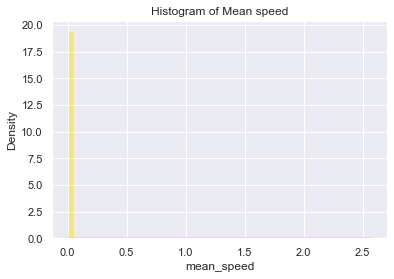

In [1374]:
X_train['mean_speed'] = X_train['haversine'] / y_train
sns_plot = sns.distplot(X_train['mean_speed'], color = 'gold')
plt.title("Histogram of Mean speed")
plt.ylabel("Density")
fig = sns_plot.get_figure()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [1375]:
print("Будем считать квантилью значение", X_train['mean_speed'].quantile(0.98))

Будем считать квантилью значение 0.010054445891352374


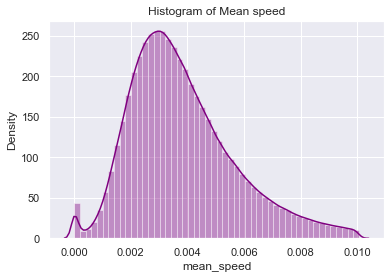

In [1376]:
normal_mean_speed = X_train.query('mean_speed < 0.010054445891352374')['mean_speed']
sns_plot = sns.distplot(normal_mean_speed, color = 'purple')
plt.title("Histogram of Mean speed")
plt.ylabel("Density")
fig = sns_plot.get_figure()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

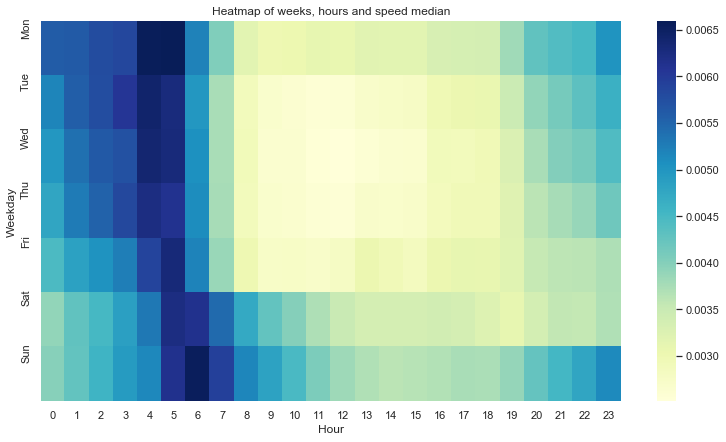

In [1377]:
Week_hour_speed = X_train.groupby(['Weekday', 'Hour']).median()['mean_speed'].to_frame().reset_index()
pivoted_table = Week_hour_speed.pivot(index='Weekday', columns='Hour', values='mean_speed')
pivoted_table.fillna(0, inplace=True)
plt.figure(figsize=(13,7))
sns.heatmap(pivoted_table, cmap="YlGnBu")
plt.yticks(np.arange(7), np.array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
plt.title('Heatmap of weeks, hours and speed median')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [1378]:
X_train.drop(columns='mean_speed', inplace=True)

**Ответ**: В тестовой выборке мы не можем определить значение скорости, так как не знаем значение времени, поэтому это значение нельзя использовать при обучении. 

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ**: Скорость максимальна с 4 до 5 утра с понедельника по пятницу и с 5 до 7 с пятницы по воскресенье. Скорость минимальна с 8 до 18 со вторника по пятницу.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [1379]:
X_train['traffic_period'] = 0
X_train['free_period'] = 0
X_train.loc[(X_train['Hour'] >= 8) & (X_train['Hour'] <= 18) & (X_train['Weekday'] >= 1) & (X_train['Weekday'] <=4),\
            'traffic_period'] = 1
X_train.loc[((X_train['Hour'] >= 4) & (X_train['Hour'] <= 5) & (X_train['Weekday'] >= 0) & (X_train['Weekday'] <= 4)) |\
            ((X_train['Hour'] >= 5) & (X_train['Hour'] <= 6) & (X_train['Weekday'] >= 5) & (X_train['Weekday'] <= 6)),\
            'free_period'] = 1
X_test['traffic_period'] = 0
X_test['free_period'] = 0
X_test.loc[(X_test['Hour'] >= 8) & (X_test['Hour'] <= 18) & (X_test['Weekday'] >= 1) & (X_test['Weekday'] <=4),\
            'traffic_period'] = 1
X_test.loc[((X_test['Hour'] >= 4) & (X_test['Hour'] <= 5) & (X_test['Weekday'] >= 0) & (X_test['Weekday'] <= 4)) |\
            ((X_test['Hour'] >= 5) & (X_test['Hour'] <= 6) & (X_test['Weekday'] >= 5) & (X_test['Weekday'] <= 6)),\
            'free_period'] = 1

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [1380]:
X_train['begin_laguardia'] = 0
X_train['begin_kennedy'] = 0
X_train['end_laguardia'] = 0
X_train['end_kennedy'] = 0
X_train.loc[(X_train['pickup_longitude'] <= -73.86) & (X_train['pickup_longitude'] >= -73.885) & \
            (X_train['pickup_latitude'] >= 40.77) & (X_train['pickup_latitude'] <= 40.78), 'begin_laguardia'] = 1
X_train.loc[(X_train['pickup_longitude'] <= -73.77) & (X_train['pickup_longitude'] >= -73.81) & \
            (X_train['pickup_latitude'] >= 40.64) & (X_train['pickup_latitude'] <= 40.655), 'begin_kennedy'] = 1
X_train.loc[(X_train['dropoff_longitude'] <= -73.86) & (X_train['dropoff_longitude'] >= -73.885) & \
            (X_train['dropoff_latitude'] >= 40.77) & (X_train['dropoff_latitude'] <= 40.78), 'end_laguardia'] = 1
X_train.loc[(X_train['dropoff_longitude'] <= -73.77) & (X_train['dropoff_longitude'] >= -73.81) & \
            (X_train['dropoff_latitude'] >= 40.64) & (X_train['dropoff_latitude'] <= 40.655),'end_kennedy'] = 1

X_test['begin_laguardia'] = 0
X_test['begin_kennedy'] = 0
X_test['end_laguardia'] = 0
X_test['end_kennedy'] = 0
X_test.loc[(X_test['pickup_longitude'] <= -73.86) & (X_test['pickup_longitude'] >= -73.885) & \
            (X_test['pickup_latitude'] >= 40.77) & (X_test['pickup_latitude'] <= 40.78), 'begin_laguardia'] = 1
X_test.loc[(X_test['pickup_longitude'] <= -73.77) & (X_test['pickup_longitude'] >= -73.81) & \
            (X_test['pickup_latitude'] >= 40.64) & (X_test['pickup_latitude'] <= 40.655), 'begin_kennedy'] = 1
X_test.loc[(X_test['dropoff_longitude'] <= -73.86) & (X_test['dropoff_longitude'] >= -73.885) & \
            (X_test['dropoff_latitude'] >= 40.77) & (X_test['dropoff_latitude'] <= 40.78), 'end_laguardia'] = 1
X_test.loc[(X_test['dropoff_longitude'] <= -73.77) & (X_test['dropoff_longitude'] >= -73.81) & \
            (X_test['dropoff_latitude'] >= 40.64) & (X_test['dropoff_latitude'] <= 40.655),'end_kennedy'] = 1

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

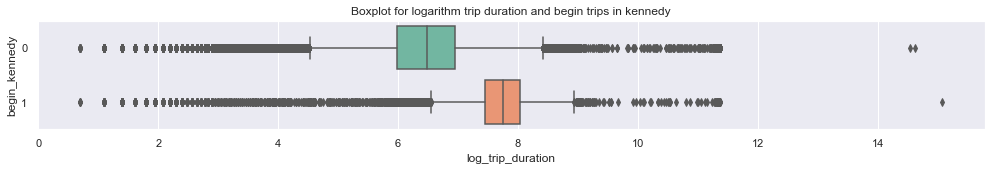

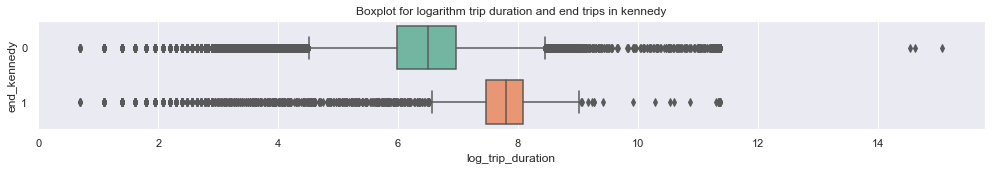

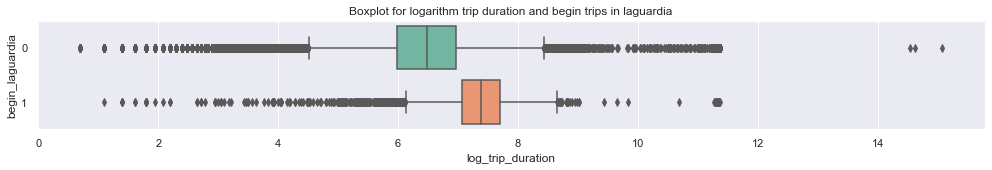

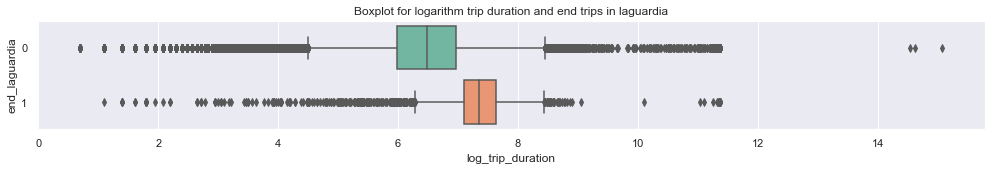

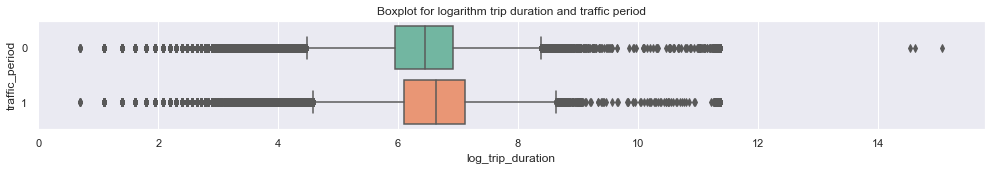

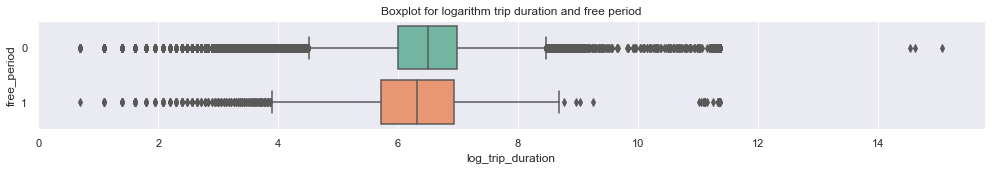

In [1381]:
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='begin_kennedy', data=X_train, orient='h', palette="Set2")
plt.title('Boxplot for logarithm trip duration and begin trips in kennedy')
plt.show()
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='end_kennedy', data=X_train, orient='h', palette="Set2")
plt.title('Boxplot for logarithm trip duration and end trips in kennedy')
plt.show()
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='begin_laguardia', data=X_train, orient='h', palette="Set2")
plt.title('Boxplot for logarithm trip duration and begin trips in laguardia')
plt.show()
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='end_laguardia', data=X_train, orient='h', palette="Set2")
plt.title('Boxplot for logarithm trip duration and end trips in laguardia')
plt.show()
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='traffic_period', data=X_train, orient='h', palette="Set2")
plt.title('Boxplot for logarithm trip duration and traffic period')
plt.show()
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='free_period', data=X_train, orient='h', palette="Set2")
plt.title('Boxplot for logarithm trip duration and free period')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: Признаки, основанные на аэропортах кажутся полезными за счёт большой разности медиан, в то время как признаки, связанные с пробками, наоборот выглядят бесполезно.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [1382]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass    
    
    def fit_transform(self, X, y=None):
        shift = 0.06
        left = X['pickup_longitude'].mean() - shift
        down = X['pickup_latitude'].mean() - shift
        width = (X['pickup_longitude'].mean() + shift - (X['pickup_longitude'].mean() - shift)) / 12
        length = (X['pickup_latitude'].mean() + shift - (X['pickup_latitude'].mean() - shift)) / 12
        Y = pd.DataFrame()
        Y['id'] = X['id']
        Y['start_cell'] = -1
        Y['fin_cell'] = -1
        cnt = 0
        for i in range(1, 13):
            for j in range(1, 13):
                cnt += 1
                Y.loc[(X['pickup_longitude'] <= left + width * i) & (left + width * (i - 1) < X['pickup_longitude']) &\
                      (X['pickup_latitude'] <= down + length * j) & (down + length * (j - 1) < X['pickup_latitude']), \
                          'start_cell'] = cnt
                Y.loc[(X['dropoff_longitude'] <= left + width * i) & (left + width * (i - 1) < X['dropoff_longitude']) &\
                      (X['dropoff_latitude'] <= down + length * j) & (down + length * (j - 1) < X['dropoff_latitude']), \
                          'fin_cell'] = cnt
        return Y
        
check_train = MapGridTransformer()   
X_train = X_train.join(check_train.fit_transform(X_train).set_index('id'), on='id')
check_test = MapGridTransformer()   
X_test = X_test.join(check_test.fit_transform(X_test).set_index('id'), on='id')
location = (X_train['pickup_latitude'].mean(), X_train['pickup_longitude'].mean())
m = folium.Map(location=location)
colors = ['red', 'gold', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'white', 'pink',\
            'lightgreen', 'gray', 'black']
for _, row in X_train.sample(6000).iterrows():
    folium.Circle(
        radius=100,
        location=(row['dropoff_latitude'], row['dropoff_longitude']),
        color=colors[(int(row['fin_cell']) + 1) % 11],
        fill_color=colors[(int(row['fin_cell']) + 1) % 11],
        fill=True
    ).add_to(m)
shift = 0.06
folium.Rectangle(bounds=[(X_train['pickup_latitude'].mean() - shift, X_train['pickup_longitude'].mean() - shift),\
                         (X_train['pickup_latitude'].mean() + shift, X_train['pickup_longitude'].mean() + shift)], color='red').\
                         add_to(m)
length = (X_train['pickup_longitude'].mean() + shift - (X_train['pickup_longitude'].mean() - shift)) / 12
width = (X_train['pickup_latitude'].mean() + shift - (X_train['pickup_latitude'].mean() - shift)) / 12
for i in range(1, 13):
    folium.PolyLine([(X_train['pickup_latitude'].mean() - shift + i * width, X_train['pickup_longitude'].mean() - shift),\
                    (X_train['pickup_latitude'].mean() - shift + i * width, X_train['pickup_longitude'].mean() + shift)],\
                    color='red').add_to(m)
for j in range(1, 13):
    folium.PolyLine([(X_train['pickup_latitude'].mean() - shift, X_train['pickup_longitude'].mean() - shift + j * length),\
                    (X_train['pickup_latitude'].mean() + shift, X_train['pickup_longitude'].mean() - shift + j * length)],\
                   color='red').add_to(m) 

X_train = X_train.drop(columns=["pickup_latitude", 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']) 
X_test = X_test.drop(columns=["pickup_latitude", 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])    

m

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [1383]:
categorical.extend(['begin_kennedy', 'end_kennedy', 'begin_laguardia', 'end_laguardia', 'free_period',\
                    'traffic_period', 'start_cell', 'fin_cell'])
numeric_features.append('log_haversine')

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])
model = pipeline.fit(X_train[[*categorical, *numeric_features]], y_log_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("Test MSE = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

Test MSE = 0.2273


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [1384]:
X_train[['vendor_id', 'passenger_count', 'store_and_fwd_flag']].nunique()

vendor_id             2
passenger_count       9
store_and_fwd_flag    2
dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

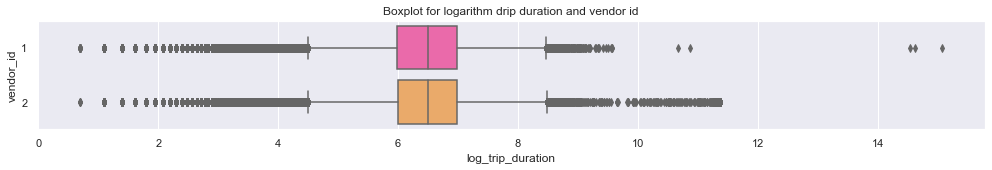

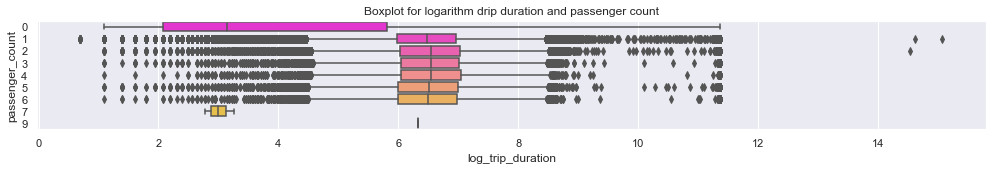

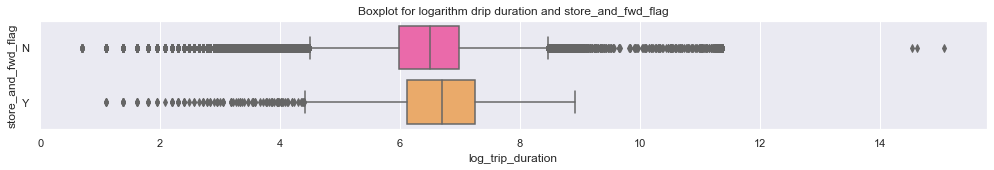

In [1385]:
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='vendor_id', data=X_train, orient='h', palette="spring")
plt.title('Boxplot for logarithm drip duration and vendor id')
plt.show()
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='passenger_count', data=X_train, orient='h', palette="spring")
plt.title('Boxplot for logarithm drip duration and passenger count')
plt.show()
plt.figure(figsize=(17,2))
sns.boxplot(x='log_trip_duration', y='store_and_fwd_flag', data=X_train, orient='h', palette="spring")
plt.title('Boxplot for logarithm drip duration and store_and_fwd_flag')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [1386]:
X_train.loc[X_train['vendor_id'] == 1, 'vendor_id'] = 0
X_train.loc[X_train['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
X_train.loc[X_train['vendor_id'] == 2, 'vendor_id'] = 1
X_train.loc[X_train['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1
X_test.loc[X_test['vendor_id'] == 1, 'vendor_id'] = 0
X_test.loc[X_test['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
X_test.loc[X_test['vendor_id'] == 2, 'vendor_id'] = 1
X_test.loc[X_test['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Судя по разности медиан, кажется, что полезным будет признак *passenger_count*, в то время как два других не сильно повлияют на предсказание.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [1387]:
categorical.extend(['vendor_id', 'store_and_fwd_flag', 'passenger_count'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = ridge_pipeline.fit(X_train[[*categorical, *numeric_features]], y_log_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("Test MSE = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

Test MSE = 0.2269


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

Метрика улучшилась на пару десятитысячных, но кто мы такие, чтобы считать эти улучшения неощутимыми.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

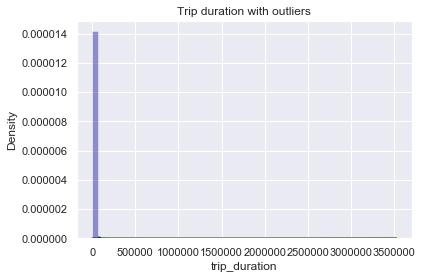

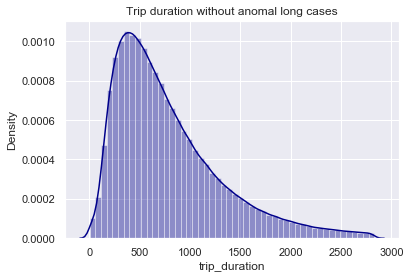

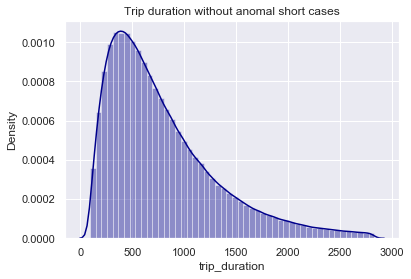

In [1388]:
sns.distplot(y_train, color='darkblue')
plt.ylabel("Density")
plt.title("Trip duration with outliers")
plt.show()
y_train.quantile(0.98)
y_train = y_train.loc[y_train < y_train.quantile(0.98)]
sns.distplot(y_train, color='darkblue')
plt.ylabel("Density")
plt.title("Trip duration without anomal long cases")
plt.show()
y_train = y_train.loc[y_train > 90]
y_log_train = y_log_train[y_log_train.index.isin(y_train.index)]
sns.distplot(y_train, color='darkblue')
plt.ylabel("Density")
plt.title("Trip duration without anomal short cases")
plt.show()
X_train = X_train[X_train.index.isin(y_train.index)]

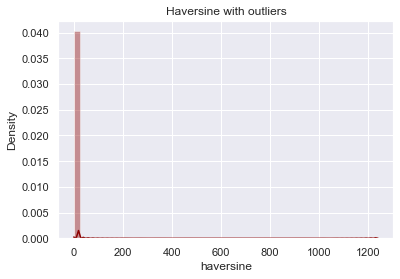

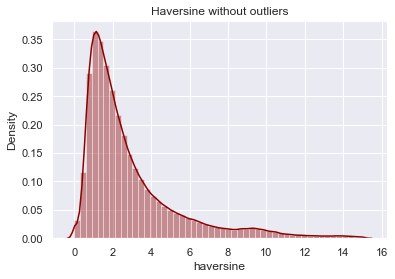

In [1389]:
sns.distplot(X_train['haversine'], color='darkred')
plt.ylabel("Density")
plt.title("Haversine with outliers")
plt.show()
X_train['haversine'].quantile(0.98)
X_train = X_train.loc[X_train['haversine'] < X_train['haversine'].quantile(0.98)]
sns.distplot(X_train['haversine'], color='darkred')
plt.ylabel("Density")
plt.title("Haversine without outliers")
plt.show()
y_train = y_train[y_train.index.isin(X_train.index)]
y_log_train = y_log_train[y_log_train.index.isin(X_train.index)]

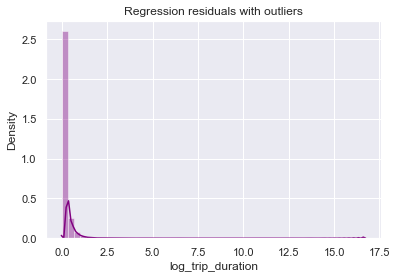

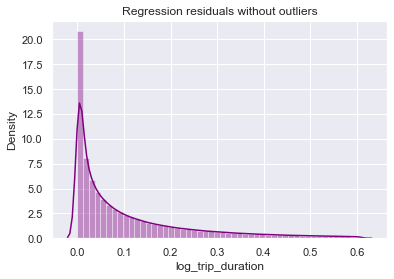

In [1390]:
error = (y_log_train - model.predict(X_train)) ** 2
sns.distplot(error, color='purple')
plt.ylabel("Density")
plt.title("Regression residuals with outliers")
plt.show()
mask = (error < np.quantile(error, 0.95))
X_train = X_train[mask]
y_train = y_train[mask]
error = (y_log_train[mask] - model.predict(X_train[mask])) ** 2
sns.distplot(error, color='purple')
plt.ylabel("Density")
plt.title("Regression residuals without outliers")
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [1391]:
from IPython.display import display

for category in categorical:
    display(X_train.groupby(category).count()['id'])

Month
1    145118
2    152281
3    163190
4    158967
5    155774
6    145958
Name: id, dtype: int64

Weekday
0    116812
1    128341
2    132710
3    137850
4    140990
5    140924
6    123661
Name: id, dtype: int64

1st_anomal
0    918073
1      3215
Name: id, dtype: int64

2nd_anomal
0    917735
1      3553
Name: id, dtype: int64

begin_kennedy
0    917312
1      3976
Name: id, dtype: int64

end_kennedy
0    921142
1       146
Name: id, dtype: int64

begin_laguardia
0    908176
1     13112
Name: id, dtype: int64

end_laguardia
0    912845
1      8443
Name: id, dtype: int64

free_period
0    905232
1     16056
Name: id, dtype: int64

traffic_period
0    631239
1    290049
Name: id, dtype: int64

start_cell
-1      42161
 3          1
 5          1
 6          2
 7          7
        ...  
 140      528
 141      281
 142        5
 143       20
 144       31
Name: id, Length: 124, dtype: int64

fin_cell
-1      69469
 3         11
 4         16
 5         22
 6         41
        ...  
 140     1655
 141      705
 142       90
 143       70
 144      217
Name: id, Length: 136, dtype: int64

vendor_id
0    429482
1    491806
Name: id, dtype: int64

store_and_fwd_flag
0    916543
1      4745
Name: id, dtype: int64

passenger_count
0        10
1    654284
2    131923
3     37566
4     17874
5     49201
6     30430
Name: id, dtype: int64

In [1394]:
X_train.drop(['end_kennedy'], axis='columns', inplace=True)
categorical.remove('end_kennedy')
X_train.loc[X_train['passenger_count'] == 0, 'passenger count'] = 6
X_train.drop(['store_and_fwd_flag'], axis='columns', inplace=True)
categorical.remove('store_and_fwd_flag')

**Ответ**: Можно заметить, что редкие категории встречаются в признаках *start_cell* и *fin_cell*, но я не стала объединять здесь ничего, так как в дальнейшем эти данные пригодятся в Задании 15. Если бы этого задания не было, то объединила бы категории здесь

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [1395]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

y_log_train = y_log_train[y_log_train.index.isin(y_train.index)]
model = ridge_pipeline.fit(X_train[[*categorical, *numeric_features]], y_log_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("Test MSE = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

Test MSE = 0.2303


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [1396]:
print("Size before OneHot:", X_train[[*categorical, *numeric_features]].shape)
print("Size after OneHot:", column_transformer.transform(X_train[[*categorical, *numeric_features]]).shape)

Size before OneHot: (921288, 16)
Size after OneHot: (921288, 299)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [1397]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train[[*categorical, *numeric_features]], y_log_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("MSE = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

MSE = 0.6334


**Ответ**: Ошибка при $l_1$ регуляризации больше, значит, этот метод лучше определяет несовершенство модели.

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [1398]:
from sklearn.model_selection import GridSearchCV

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_log_train, test_size=0.2, random_state=10)

alphas = np.logspace(-5, -2, 15)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_valid[[*categorical, *numeric_features]], y_valid)

best_alpha_lasso = searcher.best_params_["regression__alpha"]
print("Best lasso alpha = %.5f" % best_alpha_lasso)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.title('Alphas for Lasso')
plt.show()

searcher = GridSearchCV(ridge_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_valid[[*categorical, *numeric_features]], y_valid)

best_alpha_ridge = searcher.best_params_["regression__alpha"]
print("Best ridge alpha = %.5f" % best_alpha_ridge)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.title('Alphas for Ridge')
plt.ylabel("CV score")
plt.show()

Best lasso alpha = 0.00001


Best ridge alpha = 0.00032


In [1399]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])

model = lasso_pipeline.fit(X_train[[*categorical, *numeric_features]], y_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("MSE lasso = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = ridge_pipeline.fit(X_train[[*categorical, *numeric_features]], y_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("MSE ridge = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

MSE lasso = 0.2302
MSE ridge = 0.2303


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [1400]:
zeros=list()
for alpha in alphas:
    lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha))
    ])
    model = lasso_pipeline.fit(X_train[[*categorical, *numeric_features]], y_train)   
    num = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
    print("alpha = %.6f" % alpha, "\t#zeros =", num)
    zeros.append(num)
plt.scatter(x=alphas, y=zeros, color='deeppink')
plt.xlabel('alphas')
plt.ylabel('zeroes')
plt.title('Depence of the number of zeroes on alphas')
plt.show()

alpha = 0.000010 	#zeros = 100
alpha = 0.000016 	#zeros = 117
alpha = 0.000027 	#zeros = 132
alpha = 0.000044 	#zeros = 151
alpha = 0.000072 	#zeros = 167
alpha = 0.000118 	#zeros = 174
alpha = 0.000193 	#zeros = 182
alpha = 0.000316 	#zeros = 199
alpha = 0.000518 	#zeros = 216
alpha = 0.000848 	#zeros = 234
alpha = 0.001389 	#zeros = 251
alpha = 0.002276 	#zeros = 261
alpha = 0.003728 	#zeros = 276
alpha = 0.006105 	#zeros = 286
alpha = 0.010000 	#zeros = 292


In [1401]:
print('Половина признаков =', 299 / 2)

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(0.000044))
])

model = lasso_pipeline.fit(X_train[[*categorical, *numeric_features]], y_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("MSE lasso = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))
print('Ошибка становится хуже в ', mean_squared_error(y_log_test, y_pred, squared=True) / 0.2303,\
      'раз, по сравнению с предыдущим подсчётом ошибки Ridge')

Половина признаков = 149.5
MSE lasso = 0.2305
Ошибка становится хуже в  1.00086381846146 раз, по сравнению с предыдущим подсчётом ошибки Ridge


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ**: Признак потенциально полезный, так как перемещения из определённых ячеек могут косвенно влиять на скорость и время пути. Модель самостоятельно не может определить самые частовстречающиеся пары, поэтому для неё набор ячеек начала и завершения пути не играет такой роли, как в случае с приведению их к категориальным признакам.

In [1402]:
ids = X_train.groupby(['start_cell', 'fin_cell']).count().sort_values('id', ascending=False).head(100).reset_index()
ids['id'] = ids.index
ids['route'] = ids[['start_cell', 'fin_cell']].apply(tuple, axis=1)
X_train['common_route'] = -1
X_test['common_route'] = -1
X_train['route'] = X_train[['start_cell', 'fin_cell']].apply(tuple, axis=1)
X_test['route'] = X_test[['start_cell', 'fin_cell']].apply(tuple, axis=1)
X_train.loc[X_train['route'].isin(ids['route']), 'common_route'] = X_train.loc[X_train['route'].isin(ids['route']), 'route']
X_test.loc[X_test['route'].isin(ids['route']), 'common_route'] = X_test.loc[X_test['route'].isin(ids['route']), 'route']
X_train['common_route'] = X_train['common_route'].apply(str).replace(to_replace={'\(', ',', '\)', ' ', '-'},\
                                                                     value='', regex=True).apply(int)
X_test['common_route'] = X_test['common_route'].apply(str).replace(to_replace={'\(', ',', '\)', ' ', '-'},\
                                                                     value='', regex=True).apply(int)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [1403]:
categorical.append('common_route')

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = ridge_pipeline.fit(X_train[[*categorical, *numeric_features]], y_train)
y_pred = model.predict(X_test[[*categorical, *numeric_features]])
print("MSE ridge = %.4f" % mean_squared_error(y_log_test, y_pred, squared=True))

MSE ridge = 0.2251


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

**Ответ**: Согласно этой метрике, расстояние между двумя точками равно сумме модулей разностей их координат. По плану строительства Манхэттена, на острове предстояло разбить 16 авеню, проложенных с севера на юг параллельно береговой линии реки Гудзон. То есть, застройка манхэттена идеально подходит под предложенную формулу. Такой способ подсчёта может помочь нам учитывать реальный маршрут поездки, не предполагая, что машины умеют летать.

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [1404]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

<img src="https://ia.wampi.ru/2020/10/04/KARTINKA.jpg">